In [1]:
import qiskit
from qiskit import quantum_info
from qiskit.execute_function import execute
from qiskit import BasicAer
import numpy as np
import pickle
import json
import os
from collections import Counter
from sklearn.metrics import mean_squared_error
from typing import Dict, List
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

#define utility functions

def simulate(circuit: qiskit.QuantumCircuit) -> dict:
    """Simulate the circuit, give the state vector as the result."""
    backend = BasicAer.get_backend('statevector_simulator')
    job = execute(circuit, backend)
    result = job.result()
    state_vector = result.get_statevector()
    
    histogram = dict()
    for i in range(len(state_vector)):
        population = abs(state_vector[i]) ** 2
        if population > 1e-9:
            histogram[i] = population
    
    return histogram


def histogram_to_category(histogram):
    """This function take a histogram representations of circuit execution results, and process into labels as described in 
    the problem description."""
    assert abs(sum(histogram.values())-1)<1e-8
    positive=0
    for key in histogram.keys():
        digits = bin(int(key))[2:].zfill(20)
        if digits[-1]=='0':
            positive+=histogram[key]
        
    return positive


def count_gates(circuit: qiskit.QuantumCircuit) -> Dict[int, int]:
    """Returns the number of gate operations with each number of qubits."""
    counter = Counter([len(gate[1]) for gate in circuit.data])
    #feel free to comment out the following two lines. But make sure you don't have k-qubit gates in your circuit
    #for k>2
    for i in range(2,20):
        assert counter[i]==0
        
    return counter


def image_mse(image1,image2):
    # Using sklearns mean squared error:
    # https://scikit-learn.org/stable/modules/generated/sklearn.metrics.mean_squared_error.html
    return mean_squared_error(image1, image2)

In [8]:
#load the mock data (for testing only)
files=os.listdir("mock_data")
dataset=list()
for file in files:
    with open('mock_data/'+file, "r") as infile:
        loaded = json.load(infile)
        dataset.append(loaded)

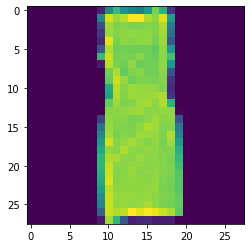

In [10]:
#load the actual hackthon data (fashion-mnist)
images=np.load('data/images.npy')
labels=np.load('data/labels.npy')
#you can visualize it
plt.imshow(images[1100])

In [13]:
flat_images = images.reshape((images.shape[0],-1))
flat_images.shape

(2000, 784)

In [14]:
pca = PCA(n_components = 16,random_state = 42)

flat_images = images.reshape((images.shape[0],-1))

pca.fit(flat_images)

# save pca in a pickle file
with open('pca.pkl', 'wb') as pickle_file:
    pickle.dump(pca, pickle_file)

In [18]:
with open("pca.pkl", "rb") as pickle_file:
    pca = pickle.load(pickle_file)

In [23]:
short_images = pca.transform(flat_images)

In [179]:
#submission to part 1, you should make this into a .py file

n=len(dataset)
mse=0
gatecount=0

shift_factor = 0.1
scale_factor = 1


# Functions 'encode' and 'decode' are dummy.
def encode(image):
    
    img = np.array(image).reshape((1,-1))
    
    with open('pca.pkl', 'rb') as pickle_file:
        pca = pickle.load(pickle_file)
    
    short_img = pca.transform(img).flatten()
    
    # now shift + scale so that the pca values end up between 0 and 1
    short_img = short_img + shift_factor
    short_img = short_img * scale_factor
    
    print(short_img)
        
    q = qiskit.QuantumRegister(16)
    circuit = qiskit.QuantumCircuit(q)
    
    # do simple angle encoding
    for i,value in enumerate(short_img):
        circuit.rx(value,i)
        
    return circuit

def decode(histogram):
    
    # need to get the probability of each qubit being 0/1
    count_zeros = np.zeros(16)
    count_ones = np.zeros(16)
    
    # count how many times each qubit was 0/1
    for i in histogram:
        bin_code = bin(i)[2:]
        if len(bin_code) < 16:
            bin_code = "0"*(16 - len(bin_code)) + bin_code
        for j,dig in enumerate(bin_code):
            if dig == "0":
                count_zeros[j] += histogram[i]
            if dig == "1":
                count_ones[j] += histogram[i]
                
    ratio = count_ones/(count_zeros + 1e-20)
    
    theta = 2.0*np.arctan(np.sqrt(ratio))
    
    # now de-scale + de-shift 
    
    theta = theta / scale_factor
    theta = theta - shift_factor
    
    print(theta)
      
    with open("pca.pkl", "rb") as pickle_file:
        pca = pickle.load(pickle_file)
        
    img = pca.inverse_transform(theta).reshape((28,28))
    
    return img

def run_part1(image):
    #encode image into a circuit
    circuit=encode(image)

    #simulate circuit
    histogram=simulate(circuit)    

    #reconstruct the image
    image_re=decode(histogram)

    return circuit,image_re

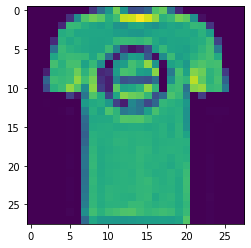

In [175]:
plt.figure()
plt.imshow(images[0,:,:])
plt.show()

In [176]:
circ,img = run_part1(images[:1,:,:])

[-0.04917868 -0.04935771 -0.0496425  -0.05101654 -0.05074661 -0.0497335
 -0.05083386 -0.04835226 -0.05132623 -0.04975665 -0.05021863 -0.04930965
 -0.0517083  -0.04116318 -0.05312421 -0.05241606]


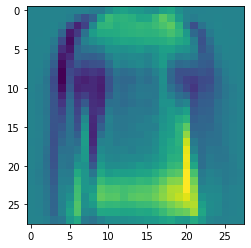

In [177]:
plt.figure()
plt.imshow(img)
plt.show()

In [178]:
img.shape

(28, 28)

In [36]:
#how we grade your submission

n=len(dataset)
mse=0
gatecount=0

for data in images[:1,:,:]:
    #encode image into circuit
    circuit,image_re=run_part1(data)
    
    #count the number of 2qubit gates used
    gatecount+=count_gates(circuit)[2]
    
    #calculate mse
    mse+=image_mse(data['image'],image_re)
    
#fidelity of reconstruction
f=1-mse
gatecount=gatecount/n

#score for part1 
print(f*(0.999**gatecount))

ValueError: Found input variables with inconsistent numbers of samples: [2, 16]

In [37]:
a = np.array([[1,2],[3,4]])

In [38]:
for i in a:
    print(i)

[1 2]
[3 4]
